# Исследование сервиса аренды самокатов

**Описание проекта** 

Сервис аренды самокатов GoFast передал данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируем данные и проверим некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
  
  *Без подписки*
  - абонентская плата отсутствует;
  - стоимость одной минуты поездки — 8 рублей;
  - стоимость старта (начала поездки) — 50 рублей;
  
  
  *С подпиской Ultra*
  - абонентская плата — 199 рублей в месяц;
  - стоимость одной минуты поездки — 6 рублей;
  - стоимость старта — бесплатно.
  
**Цель исследования**

Определить поведение пользоватей сервиса с подпиской и без. Сопоставить выручку, а также разработать методику для выявления аномалий в данных, которая может быть использована в автоматизированных системах.

**Ход исследования:**
- Подготовка данных: загрузка и изучение общей информации из предоставленных датасетов.
- Предобработка данных: обработка пропущенных значений, корректировка типа данных, дубликатов и других аномалий.
- Расширение набора данных, объединение таблиц, добавление столбца с выручкой на каждого пользователя по месяцам.
- Исследовательский анализ данных: изучение основных параметров объектов, их распределения, зависимостей, а также выявление и обработка аномалий.
- Формирование гипотез для сравнения метрик в совокупности пользователей с подпиской и без.

**Общий вывод**

С помощью данного иследования мы постараемся выявить интересные и полезные зависимости для бизнеса, дать рекомендации для улучшения сервиса и увеличения выручки компании.

### Общая информация о данных и предобработка

Импортируем необходимые библиотеки. Далее выведем общую информацию о датасете, посмотрим первые пять строк для понимания структуры данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

In [2]:
pd.set_option('display.max_columns', None)

#### Шаг 1. Загрузка данных

**Данные о пользователях**

In [3]:
users = pd.read_csv('/datasets/users_go.csv')
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


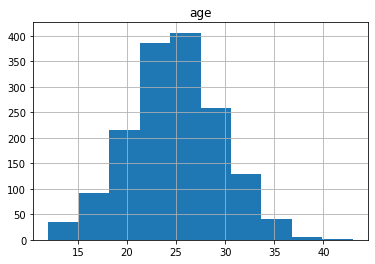

In [5]:
users.hist('age');

In [6]:
users.describe()

,user_id,age
count,1565.000000,1565.000000
mean,762.633866,24.922045
std,443.260155,4.553496
min,1.000000,12.000000
25%,378.000000,22.000000
50%,762.000000,25.000000
75%,1146.000000,28.000000
max,1534.000000,43.000000


В датасете с пользователями пропусков нет, типы данных соответствуют ожидаемым. Аномалий в данных не обнаружено. Возраст распределен нормально.

Проверим дубликаты.

In [7]:
users.duplicated().sum()

31

В данных есть дубликаты. Удалим их.

In [8]:
users = users.drop_duplicates()
users.duplicated().sum()

0

Отдельно проверим нет ли дубликатов в столбце user_id.

In [9]:
len(users)

1534

In [10]:
users['user_id'].nunique()

1534

Число уникальных id равно числу строк в датасете. Значит дубликатов id нет. Бывают ситуации когда id может быть одинаковым у двух разных пользователей. 

**Данные о пoездках**

In [11]:
rides = pd.read_csv('/datasets/rides_go.csv')
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


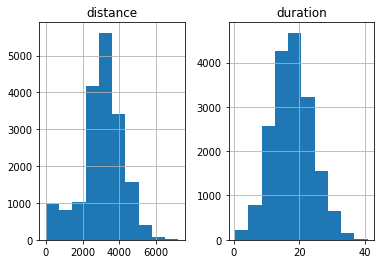

In [12]:
rides.hist(['distance', 'duration']);

In [13]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [14]:
rides.describe()

,user_id,distance,duration
count,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,17.805011
std,434.734317,1116.831209,6.091051
min,1.000000,0.855683,0.500000
25%,487.000000,2543.226360,13.597563
50%,889.000000,3133.609994,17.678395
75%,1213.250000,3776.222735,21.724800
max,1534.000000,7211.007745,40.823963


В датасете o поездках пропусков нет, типы данных соответствуют ожидаемым, кроме даты. По распределениям данных и при вызове метода describe видим, что есть совсем короткие поездки, где дистанция меньше метра и время поездки  менее минуты. Более внимательно изучим эти данные. Отфильтруем сначала поездки с дистанцией менее метра, а затем со временем сессии менее минуты.

In [15]:
rides[rides['distance'] < 1]

,user_id,distance,duration,date
11555,1069,0.855683,10.001902,2021-01-31


Поездка с дистанцией менее метра всего одна. При этом время сессии 10 минут. Возможно пользователь взял на прокат самокат и не смог понять как им пользоваться. Пытаясь разобраться в нем 10 минут и проехав всего 0,85м, он решил закончить поездку. Эту строку не будем удалять из данных. 

Отфильруем данные, где поездка заняла менее минуты.

In [16]:
rides[rides['duration'] < 1]

,user_id,distance,duration,date
6531,701,4196.445201,0.5,2021-08-31
6570,704,4830.824371,0.5,2021-10-14
6680,712,4684.004397,0.5,2021-03-04
6695,713,5215.642710,0.5,2021-02-25
6768,718,5197.436649,0.5,2021-02-11
...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19
17242,1477,6724.932981,0.5,2021-01-12
17314,1483,4445.481070,0.5,2021-03-06
17505,1496,5722.551787,0.5,2021-02-14


Видим, что таких строк 95 штук. Отбрасить их - значит потерять 95/18068 = 0.52 процента данных. Попробуем проанализировать эти поездки. Посмотрим распределение дистанции для поездок менее 1 минуты, затем посмотрим среднее время поездки для такого же промежутка дистанций во всем датафрейме, предварительно отфильтровав данные и отбросив поездки менее минуты.

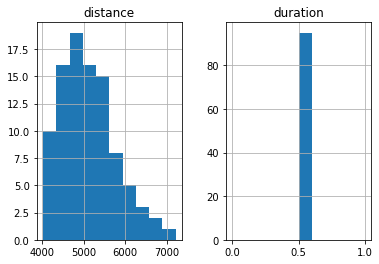

In [17]:
rides[rides['duration'] < 1].hist(['distance', 'duration']);

In [18]:
rides[rides['duration'] < 1].describe()

,user_id,distance,duration
count,95.000000,95.000000,95.0
mean,1092.210526,5113.176549,0.5
std,244.028551,658.254104,0.0
min,701.000000,4030.308008,0.5
25%,901.000000,4611.510820,0.5
50%,1069.000000,5052.769411,0.5
75%,1310.500000,5488.459099,0.5
max,1524.000000,7211.007745,0.5


Видим, что дистанция 4-7 км. Скорее всего речь идет не о 0,5 минутах, а 0,5 часов, т.е. 30 минутах. Посмотрим на среднее время поездки для дистанции 4-7 км для отфильтрованных данных.

In [19]:
rides.query('duration > 0.5 & 4000 < distance < 7000')

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
4,1,4028.687306,26.265803,2021-08-28
10,1,4031.020195,17.674448,2021-12-14
14,2,4029.116927,25.109188,2021-03-23
32,3,5335.212090,25.848038,2021-07-14
...,...,...,...,...
18034,1532,4602.642357,32.013212,2021-08-21
18040,1532,4551.698449,31.007839,2021-12-21
18053,1533,4581.943632,21.163887,2021-08-27
18055,1534,4678.415899,15.228198,2021-01-20


Посмотрим на среднее и медиану.

In [20]:
rides.query('duration > 0.5 & 4000 < distance < 7000')['duration'].mean()

22.167685870417856

In [21]:
rides.query('duration > 0.5 & 4000 < distance < 7000')['duration'].median()

21.88701680383494

В случае с данными о пользователях, которые используют самокаты, если оплата за эти данные была получена, то они представляют собой реальные наблюдения, а не аномалии или выбросы. Удалять такие наблюдения может привести к потере важной информации и возможным искажениям результатов и выводов на основе анализа данных. Поэтому данные мы сохраняем в исходном виде.

Проверим дубликаты.

In [23]:
rides.duplicated().sum()

0

Дубликатов в данных нет.

**Данные о пoдписках**

In [24]:
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [25]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


В данных о подписке всего две строки с описанием деталей сервиса. Согласно задаче у нас всего два типа мобильного приложения (с подпиской и без подписки)

### Предобработка данных

#### Шаг 2. Предобработка данных

Приведем столбец date к типу даты pandas в датасете rides

In [26]:
rides['date'] = pd.to_datetime(rides['date'])

Создадим новый столбец в датасете rides с номером месяца

In [27]:
rides['month'] = rides['date'].dt.month
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


**Общий вывод после ознакомления с данными и предобработки**

В данных нет пропусков, в основном данные не имеют аномалий (например, возраст менее 7 лет или более 60 лет). В 95 строках с дистанцией от 4 до 7 км время поездки составило всего 30 секунд. Это следует отдельно изучить. Возможно данные некорректно выгрузились, возможно счетчик времени дает какие-то сбои. Было принято решение эти данные не удалять, а заменить время поездки на среднее время при дистанции 4-7км, предварительно отфильтровав данные без учета 30 секундных поездок. Кроме того следует дополнительно проанализировать поездки на совсем короткие дистанции, но при этом с длиной сессии более нескольких минут. Возможно пользователи испытывают трудности с управлением самоката, что может вести к потере клиентов.

Столбец с датой был приведен к типу дата-время, отдельно добавлен столбец с номером месяца.

### Исследовательский анализа данных

#### Шаг 3. Исследовательский анализ данных

Опишем и визуализируем общую информацию о пользователях и поездках:
 - частота встречаемости городов;
 - соотношение пользователей с подпиской и без подписки;
 - возраст пользователей;
 - расстояние, которое пользователь преодолел за одну поездку;
 - продолжительность поездок.


**Города, где чаще всего пользуются самокатами**

In [28]:
#выведем частотность городов
users['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

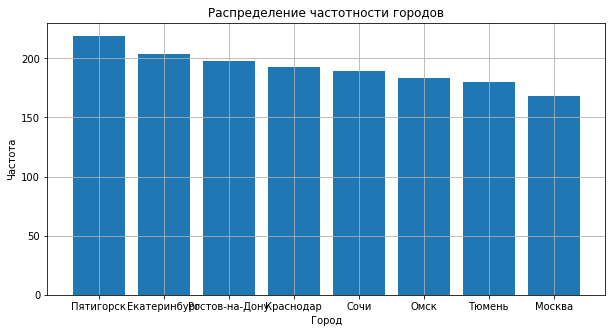

In [29]:
#построим barplot распределения частотности городов
plt.figure(figsize=(10,5))
plt.bar(users['city'].value_counts().index, users['city'].value_counts().values)
plt.xlabel('Город')
plt.ylabel('Частота')
plt.title('Распределение частотности городов')
plt.grid()
plt.show()

Видим очень интересное распределение. Оказывается самокатами чаще всего пользуются не в Москве, а в Пятигорске.

**Соотношение пользователей с подпиской и без**

In [30]:
#выведем информацию о долях пользователей
users['subscription_type'].value_counts(normalize=True)

free     0.544329
ultra    0.455671
Name: subscription_type, dtype: float64

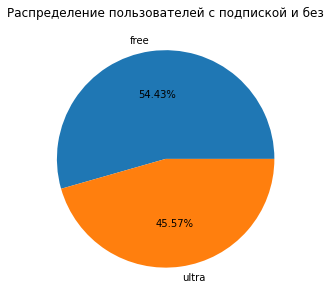

In [31]:
#построим barplot распределения частотности городов
plt.figure(figsize=(10,5))
plt.pie(users['subscription_type'].value_counts(normalize=True), labels=users['subscription_type'].value_counts(normalize=True).index, autopct='%1.2f%%')
plt.title('Распределение пользователей с подпиской и без')
plt.show()

Видим, что пользователей без подписки больше, чем с подпиской. Поэтому имеется смысл изучить поведение пользователей без подписки и побудить их приобрести ее.

**Возраст пользователей**

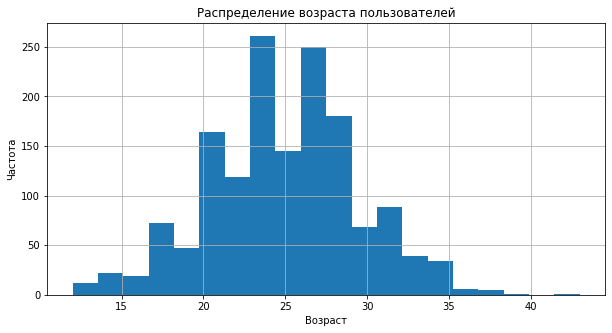

In [32]:
#построим гистограмму распределения возраста пользователей
plt.figure(figsize=(10,5))
plt.hist(users['age'], bins=20)
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.title('Распределение возраста пользователей')
plt.grid()
plt.show()

In [33]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Из графика распределения и при вызове метода describe видим, что сервисом аренды самокатов пользуются клиенты от 12 до 43 лет, основная часть клиентов до 28 лет. Аномалий нет.

**Расстояние, которое пользователь преодолел за одну поездку**

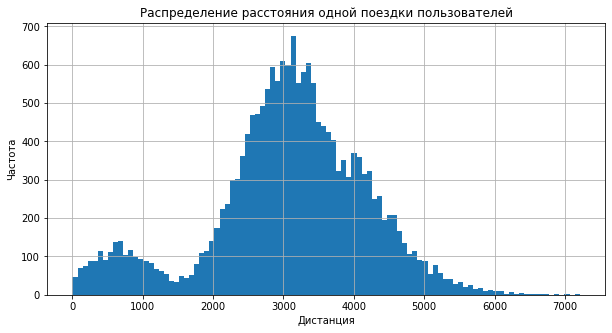

In [34]:
#построим гистограмму распределения расстояния одной поездки
plt.figure(figsize=(10,5))
plt.hist(rides['distance'], bins=100)
plt.xlabel('Дистанция')
plt.ylabel('Частота')
plt.title('Распределение расстояния одной поездки пользователей')
plt.grid()
plt.show()

In [35]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Из графика распределения дистанции видим, что оно бимодальное. Чаще всего клиенты берут в аренду самокат для поездок на дистанцию около 3 км, что является разумным. Идти пешком 3 км довольно долго, особенно если это поездки от дома до метро или до работы. Быстрее доехать на самокате. Реже всего встречаются поездки от 5 до 7 км, что тоже объяснимо. Поездка в 7 км на самокате не самое приятное удовольствие, особенно если погода не лучшая. Как упоминали выше, следует дополнительно проанализировать совсем короткие дистанции, чтобы убедиться, что пользователи не испытывают трудности с управлением самокатом.

**Продолжительность поездок**

Ранее мы уже провели предобработку данных по продолжительности поездки и заменили аномальные данные. Если бы поездка была около 30 секунд, но при этом и дистанция была бы менее 1м, можно было принять решение отбросить такие данные. Но при анализе мы увидели, что все поездки с длительностью 30 секунд имели дистанцию 4-7км. Поэтому было решение заменить аномальные данные. 

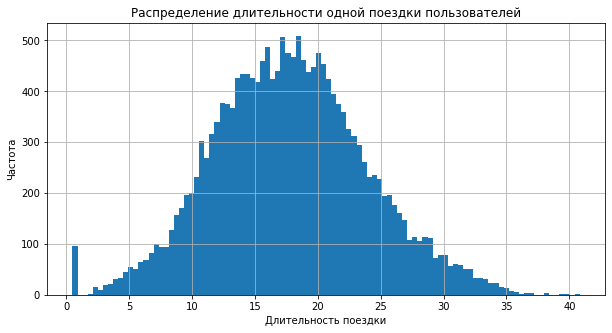

In [36]:
#построим гистограмму распределения времени одной поездки
plt.figure(figsize=(10,5))
plt.hist(rides['duration'], bins=100)
plt.xlabel('Длительность поездки')
plt.ylabel('Частота')
plt.title('Распределение длительности одной поездки пользователей')
plt.grid()
plt.show()

In [37]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Из графика распределения времени поездки  видим, что оно нормальное. В основном пользователи берут самокат на прокат до 21 минуты, что не является аномальным значением. В данных есть данные с маленькой продолжительностью поездки до 5 минут, но мы не будем удалять эти данные. Бывают ситуации, когда пользователь очень куда-то опаздывает, и появляется необходимость быстро добраться до места назначения. Например, до метро, чтобы вовремя доехать на собеседование. Поездка в три минуты, может сэкономить 5-10 минут.

**Общий вывод из исследовательского анализа данных**

- Самокаты чаще всего используются не в Москве, а в Пятигорске.
- Число пользователей без подписки больше, чем с подпиской. 
- Сервисом аренды самокатов пользуются клиенты от 12 до 43 лет, основная часть клиентов до 28 лет.
- График распределения дистанций бимодальный. Чаще всего клиенты берут в аренду самокат для поездок на дистанцию около 3 км. Реже всего встречаются поездки от 5 до 7 км. Следует дополнительно проанализировать совсем короткие дистанции, чтобы убедиться, что пользователи не испытывают трудности с управлением самокатом.
- График распределения времени поездки  нормальный. В основном пользователи берут самокат на прокат до 21 минуты. Но также присутсвуют совсем короткие промежутки времени поездки. Это следует дополнительно отдельно изучить.

### Объединение данных

#### Шаг 4. Объединение данных

Объединим данные о пользователях, поездках и подписках в один датафрейм. Для этого воспользуемся методом merge(). Перед объединением проверим количество уникальных пользователей в датафрейме users и rides.

In [38]:
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [39]:
users['user_id'].nunique()

1534

In [40]:
rides['user_id'].nunique()

1534

Количество совпадает, поэтому используем тип объединения inner. 

Перед объединением проверим длину каждого датафрема, а затем исходного.

In [41]:
#длина датасета с пользователями
len(users)

1534

In [42]:
#длина датасета с поездками пользователей
len(rides)

18068

In [43]:
df_total = pd.merge(users, rides, on='user_id')

In [44]:
df_total.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8


In [45]:
#Длина промежуточного датасета
len(df_total)

18068

Длина промежуточного датасета равна длине датасета с поездками. Объединение прошло корректно.
Проверки пропуски.

In [46]:
df_total.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
dtype: int64

In [47]:
#присоединим информацию о тарифе
df_total = pd.merge(df_total, subscriptions, on='subscription_type')

In [48]:
df_total.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [49]:
#длина датафрейма
len(df_total)

18068

In [50]:
#проверим пропуски
df_total.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Создим ещё два датафрейма: 
 - c данными о пользователях без подписки
 - с данными о пользователях с подпиской

In [51]:
df_sub_yes = df_total[df_total['subscription_type'] == 'ultra']
df_sub_yes.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [52]:
df_sub_no = df_total[df_total['subscription_type'] != 'ultra']
df_sub_no.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий

**Пользователи с подпиской**

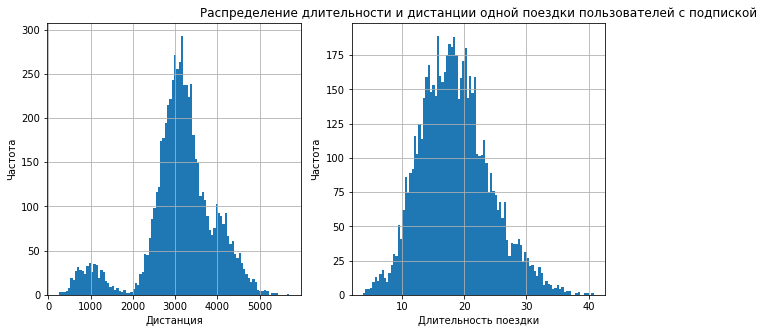

In [53]:
plt.figure(figsize=(10,5))
plt.subplot(121) 
plt.hist(df_sub_yes['distance'], bins=100)
plt.xlabel('Дистанция')
plt.ylabel('Частота')
plt.grid()

plt.subplot(122) 
plt.hist(df_sub_yes['duration'], bins=100)
plt.xlabel('Длительность поездки')
plt.ylabel('Частота')
plt.grid()

plt.title('Распределение длительности и дистанции одной поездки пользователей с подпиской')
plt.show()

**Пользователи без подписки**

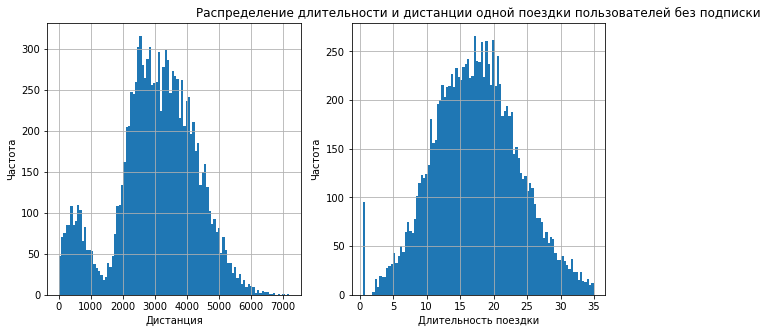

In [54]:
plt.figure(figsize=(10,5))
plt.subplot(121) 
plt.hist(df_sub_no['distance'], bins=100)
plt.xlabel('Дистанция')
plt.ylabel('Частота')
plt.grid()

plt.subplot(122) 
plt.hist(df_sub_no['duration'], bins=100)
plt.xlabel('Длительность поездки')
plt.ylabel('Частота')
plt.grid()

plt.title('Распределение длительности и дистанции одной поездки пользователей без подписки')
plt.show()

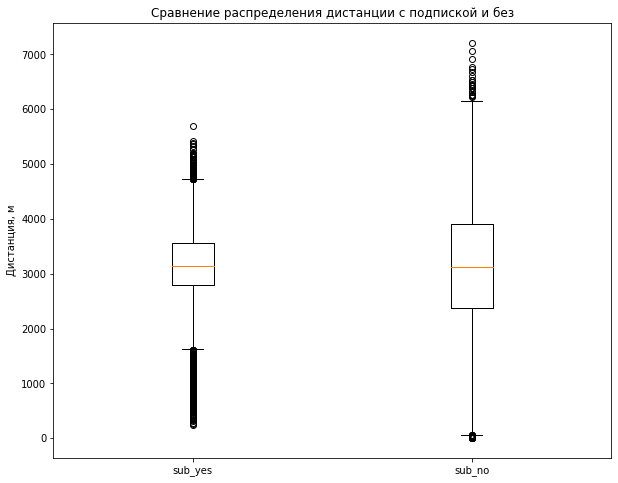

In [55]:
plt.figure(figsize=(10, 8))
plt.boxplot([df_sub_yes['distance'], df_sub_no['distance']], labels=['sub_yes', 'sub_no'])

plt.title('Сравнение распределения дистанции с подпиской и без')
plt.ylabel('Дистанция, м')

plt.show()

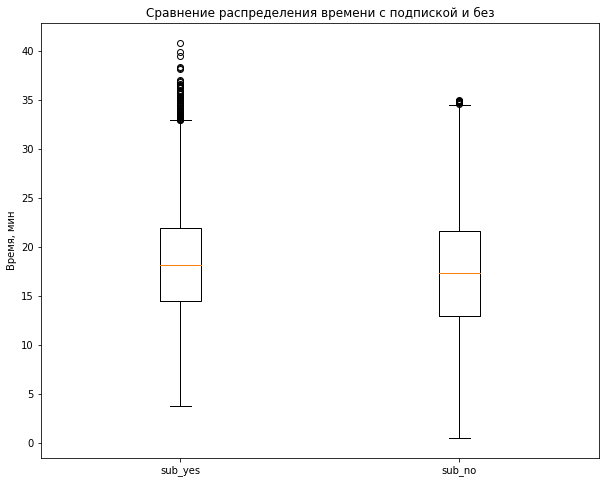

In [56]:
plt.figure(figsize=(10, 8))
plt.boxplot([df_sub_yes['duration'], df_sub_no['duration']], labels=['sub_yes', 'sub_no'])

plt.title('Сравнение распределения времени с подпиской и без')
plt.ylabel('Время, мин')

plt.show()

**Общий вывод после объединения и визуализации данных**

Из графиков распределения видим, что они похожи для пользователей с подпиской и без. Длительность поездки для обоих групп в основном лежит до 20 минут, но в данных с платной подпиской больше поездок более 20 минут, чем в данных без подписки. Что логично. Без подписки минута стоит дороже.


Картина с дистанцией интереснее. 
Мы видим, что пользователи без подписки чаще берут самокат на короткие дистанции от 0 до 2 км. Возможно это группе стоит предложить подписку, чтобы не платить за старт. 

Также наблюдается интересная картина при изучении ящиков с усами. Мы видим, что пользователи с подпиской проезжают более короткие дистанции в сравнении с пользователями без подписки. Причем у последних есть аномально большие дистанции. Но при наблюдаем, что длительность сессии у пользователей без подписки короче. Напрашивается вывод, что пользователи без подписки в целях экономии средств превышают скоростной режим. Возможно, следует ввести какую-то политику безопасности для имиджа компании, либо при привышении скорость резко увеличивать стоимость минуты, чтобы побуждать пользователей соблюдать безопасность на дороге и покупать подписку. 

В целом медианы длительности и дистанций для пользователей с подпиской и без практически одинаковые, что хорошо видно на графике boxplot.

### Выручка

#### Шаг 5. Подсчёт выручки

Создим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными df_total: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [57]:
df_total.groupby(['user_id', 'month']).agg({'duration':['sum'], 'distance':['sum','count']})

duration      distance      
                     sum           sum count
user_id month                               
1       1      41.416640   7027.511294     2
        4       6.232113    754.159807     1
        8      44.776802   6723.470560     2
        10     31.578017   5809.911100     2
        11     53.397424   7003.499363     3
...                  ...           ...   ...
1534    6      24.812678   3409.468534     2
        8      47.205960   7622.453034     2
        9      22.560373   4928.173852     1
        11     76.342174  13350.015305     4
        12     15.893917   2371.711192     1

[11331 rows x 3 columns]

In [58]:
df_agg = df_total.groupby(['user_id', 'month']).agg({'duration':['sum'], 'distance':['sum','count']})
df_agg = df_agg.reset_index()
df_agg.head()

user_id month   duration     distance      
                       sum          sum count
0       1     1  41.416640  7027.511294     2
1       1     4   6.232113   754.159807     1
2       1     8  44.776802  6723.470560     2
3       1    10  31.578017  5809.911100     2
4       1    11  53.397424  7003.499363     3

In [59]:
df_agg.columns = ['user_id', 'month', 'sum_duration', 'sum_distance',  'count_rides']
df_agg.head()

,user_id,month,sum_duration,sum_distance,count_rides
0,1,1,41.416640,7027.511294,2
1,1,4,6.232113,754.159807,1
2,1,8,44.776802,6723.470560,2
3,1,10,31.578017,5809.911100,2
4,1,11,53.397424,7003.499363,3


В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратимся к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округляем до следующего целого числа.

In [60]:
df_agg = pd.merge(df_agg, users[['subscription_type', 'user_id']])
df_agg.head()

,user_id,month,sum_duration,sum_distance,count_rides,subscription_type
0,1,1,41.416640,7027.511294,2,ultra
1,1,4,6.232113,754.159807,1,ultra
2,1,8,44.776802,6723.470560,2,ultra
3,1,10,31.578017,5809.911100,2,ultra
4,1,11,53.397424,7003.499363,3,ultra


In [62]:
df_agg = pd.merge(df_agg, subscriptions)
df_agg.head()

,user_id,month,sum_duration,sum_distance,count_rides,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,41.416640,7027.511294,2,ultra,6,0,199
1,1,4,6.232113,754.159807,1,ultra,6,0,199
2,1,8,44.776802,6723.470560,2,ultra,6,0,199
3,1,10,31.578017,5809.911100,2,ultra,6,0,199
4,1,11,53.397424,7003.499363,3,ultra,6,0,199


In [63]:
df_agg['sum_duration'] = df_agg['sum_duration'].apply(np.ceil)

In [64]:
df_agg['total_income'] = (df_agg['sum_duration'] * df_agg['minute_price']) + (df_agg['start_ride_price'] * df_agg['count_rides']) + df_agg['subscription_fee']

In [65]:
df_agg.head()

,user_id,month,sum_duration,sum_distance,count_rides,subscription_type,minute_price,start_ride_price,subscription_fee,total_income
0,1,1,42.0,7027.511294,2,ultra,6,0,199,451.0
1,1,4,7.0,754.159807,1,ultra,6,0,199,241.0
2,1,8,45.0,6723.470560,2,ultra,6,0,199,469.0
3,1,10,32.0,5809.911100,2,ultra,6,0,199,391.0
4,1,11,54.0,7003.499363,3,ultra,6,0,199,523.0


**Общий вывод после объединения таблиц**

Создали сводный датафрей, где подсчитали агрегированные метрики за месяц (длительность, дистанция, количество поездок). И самое главное - посчитали выручку, которую принес каждый пользователь за определенный месяц.

### Проверка гипотез

#### Шаг 6. Проверка гипотез

**Гипотеза о длительности сессии**

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.

Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверим гипотезу. Используем исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Нулевая гипотеза: 
 - средние значения трат времени пользователей из двух групп равны.
 
Альтернативная гипотеза: 
 - среднее значение трат времени пользователей с подпиской больше, чем среднее значение трат пользователей без подписки.
 
Для проверки гипотез используем t-тест, так как соблюдаются условия для теста:
 - генеральные совокупности не зависят друг от друга
 - выборочные средние нормально распределены
 - дисперсии рассматриваемых генеральных совокупностей равны. (Это коварное условие. С одной стороны, мы никогда точно не знаем, равны ли дисперсии рассматриваемых генеральных совокупностей. С другой — по умолчанию параметр equal_var принимает значение True: дисперсии считаются равными и тест объединяет обе выборки в одну, чтобы эту дисперсию поточнее оценить. При этом если выборки достаточно велики (30 и больше значений) и равны по размеру между собой, то такой подход оправдан. Симуляции, проведённые учёными, показывают, что даже если дисперсии на самом деле не равны, то тест редко ошибается.)

Проверим размер выборок.

In [66]:
len(df_sub_yes)

6500

In [67]:
len(df_sub_no)

11568

Выборки не равны, но Т-тест разработан как точный тест, который учитывает неодинаковые размеры выборки и неодинаковые дисперсии двух совокупностей.

In [68]:

# задаём уровень значимости
alpha = 0.05

# траты времени первой группы пользователей (с подпиской)
first_group = df_sub_yes['duration']

# траты времени второй группы пользователей (без подписки)
second_group = df_sub_no['duration']

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(first_group, second_group, alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Мы отвергаем нулевую гипотезу. На основе наших данных и при заданном уровне значимости у нас нет достаточно оснований отвергнуть альтернативную гипотезу о том, что пользователи с подпиской тратят больше времени на поездки.

**Гипотеза о расстоянии одной поездки**

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Проверим, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров. 

Нулевая гипотеза: 
 - среднее расстояние одной поездки пользователя с подпиской не превышает 3130 метров.
 
Альтернативная гипотеза: 
 - среднее расстояние одной поездки пользователя с подпиской превышает 3130 метров.

In [69]:

distance_sub_yes = df_sub_yes['distance']

interested_value = 3130 # оптимальное расстояние с точки зрения износа самоката

alpha = 0.05 # уровень статистической значимости
           
results = st.ttest_1samp(distance_sub_yes, interested_value, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


По итогам теста на основании наших данных и при заданном уровне значимости у нас нет оснований отвергнуть нулевую гипотезу о том, что среднее расстояние поездки пользователей с подпиской превышает 3130 метров.

**Гипотеза о выручке на пользователя с подпиской и без подписки**

Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

Нулевая гипотеза: 
 - выручка от пользователей с подпиской и без подписки не различается.
 
Альтернативная гипотеза: 
 - выручка от пользователей с подпиской выше выручки пользователей без подписки.

In [70]:
# задаём уровень значимости
alpha = 0.05

# выручка в месяц первой группы пользователей (с подпиской)
first_group = df_agg[df_agg['subscription_type'] == 'ultra']['total_income']

# выручка в месяц второй группы пользователей (без подписки)
second_group = df_agg[df_agg['subscription_type'] == 'free']['total_income']

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(first_group, second_group, alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 2.8130926188487286e-35
Отвергаем нулевую гипотезу


По итогам теста на основании наших данных и при заданном уровне значимости у нас нет оснований отвергнуть альтернативную гипотезу о том, что пользователи с подпиской приносят больше выручки.

**Какой выбрать тест** 

Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Для проверки гипотезы о количестве обращений пользователей можно использовать т-тест. У нас будет две генеральные совокупности - количество обращений пользователей до обновления и число обращений после обновления. Если генеральные совокупности не большие по размеру, то мы их и используем для проведения теста. Если же большие, то мы возьмем некоторые выборки из них (более 30 штук на каждую совокупность).

Сформулируем гипотезы:
- нулевая гипотеза - количество обращение осталось прежним
- альтернативная гипотеза - количество обращений снизилось

Для проведения теста используем метод scipy.stats.ttest_ind(array1, array2, equal_var, alternative)

У метода несколько параметров:
 - array1, array2 — наборы значений, которые содержат выборки.
- equal_var (от англ. equal variance — «равная дисперсия») — необязательный параметр. Он управляет тем, будет ли метод считать равными дисперсии выборок. Передаётся как equal_var=True или equal_var=False (True — считать, False — не считать). По умолчанию — True.
- alternative — текстовый параметр, задающий альтернативную гипотезу. Варианты: 'two-sided', 'less', 'greater' (соответственно, двусторонняя, левосторонняя и правосторонняя.

В нашем случае код будет выглядеть так

scipy.stats.ttest_ind(выборка до обновления, выборка после обновления, alternative='less')

### Общий вывод

**Описание проекта** 

Проведен анализ данных о сервисе аренды самокатов. При работе использовано три датасета, содержащие данные о пользователях, их поездках, деталях тарифного плана.

**Ход исследования** 

Перед началом аналитической работы было проведено изучение данных датасетов на тип, наличие дубликатов и пропусков. Далее был проведен исследовательский анализ данных, построены визуализации для поиска аномалий и интересных зависимостей. Произведена проверка на наличие дубликатов. Отдельно проверено были ли дубликаты в id у двух совершенно разных пользователей. Изучили соотношение пользователей с подпиской и без, сделана визуализация городов, где чаще всего используются самокаты. Изучили распределение возраста пользователей, аномалий здесь не выявлено. 

**Выявленные аномалии и гипотезы почему такое могло произойти** 

В ходе исследования удалось выявить аномально короткие поездки в 30 секунд с дистанциями 4-7 км. Такое могло произойти либо из-за сбоя в приложении, либо неправильной работы счетчика времени. Возможно, приложение имеет уязвимые места, и пользователь может мошеннически сбросить время. Это следует отдельно проверить. Для дальнейшего анализа было принято решение эти данные не удалять. 

При построении визуализаций времени и дистанции пользователей с подпиской и без была замечена тенденция, что пользователи с подпиской преодолевают меньшие дистанции, чем пользователи без подписки, но при этом время использования сервиса у них больше. Напрашивается вывод, что пользователи без подписки в целях экономии времени и соответственно денег не соблюдают скоростной режим. Это может привести к негативным последствиям как для имиджа компании, так для выручки и затрат компании. Вырастет количество инцидентов, повысится износ самокатов, упадет выручка. Возможно следует ввести политику безопасного вождения и при превышении определенного порога скорости, резко увеличивать тариф.


**Постановка и проверка гипотез**


Для углубленного анализа и выдвижения гипотез произведена агрегация метрик. В результате получен отдельный датасет, где для каждого пользователя подсчитали выручку, которую он приносит в месяц. 

После построения визуализаций был сделан предварительный вывод, что пользователи с подпиской тратят больше времени на поездки, чем пользователи без нее. Чтобы проверить эту гипотезу был проведен статистический тест. На основе наших данных и при заданном уровне значимости у нас не было достаточно оснований отвергнуть эту гипотезу.

Далее была проверена гипотеза о том, что средняя дистанция одной поездки пользователей с подпиской не превышает рекомендованных 3130м. После проведения теста эту гипотезу мы не отвергли.

И в завершение проверили гипотезу о том, что пользователи с подпиской приносят большую выручку, чем пользователи без нее. После проведения теста и эту гипотезу мы не смогли отвергнуть. 
